## Decision tree classifier to predict whether a customer will purchase a product or service based on their demographic and behavioral data

#### Source: https://archive.ics.uci.edu/dataset/222/bank+marketing

### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import html5lib
import requests
import zipfile
import io
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import recall_score, accuracy_score, confusion_matrix, classification_report
from sklearn.feature_selection import SelectKBest, f_classif #test Anova
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings('ignore')

### Load Data

In [2]:
# Path of the current working directory
cwd_path = os.getcwd()

# Download the zip file from the URL
url = 'https://archive.ics.uci.edu/static/public/222/bank+marketing.zip'
response = requests.get(url)

# Extract the outer zip file
with zipfile.ZipFile(io.BytesIO(response.content)) as outer_zip:
    # Iterate through files in the outer zip
    for file_name in outer_zip.namelist():
        # If the file is an inner zip file
        if file_name.endswith('.zip'):
            # Extract the inner zip file from memory
            with outer_zip.open(file_name) as inner_zip_file:
                with zipfile.ZipFile(io.BytesIO(inner_zip_file.read())) as inner_zip:
                    # Extract CSV files from the inner zip
                    for inner_file_name in inner_zip.namelist():
                        if inner_file_name.endswith('.csv'):
                            # Extract CSV file
                            csv_data = inner_zip.open(inner_file_name)
                            base_name = os.path.basename(inner_file_name)   # delete that line if we want to keep folder structure
                            # Save the CSV file to disk
                            csv_output_path = os.path.join('.', base_name)    # replace here base_name by inner_file_name if we want to keep folder structure
                     #       os.makedirs(os.path.dirname(csv_output_path), exist_ok=True)    # add this line if we want to keep folder structure
                            with open(csv_output_path, 'wb') as f:
                                f.write(csv_data.read())
                                print(f'Extracted CSV file: {csv_output_path}')

Extracted CSV file: .\bank-full.csv
Extracted CSV file: .\bank.csv
Extracted CSV file: .\bank-additional-full.csv
Extracted CSV file: .\bank-additional.csv


In [3]:
dataset = pd.read_csv('bank-full.csv', sep=';')

In [4]:
df = dataset.copy()
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [5]:
df['default'].value_counts()

default
no     44396
yes      815
Name: count, dtype: int64

### Table of variables

###### job	 -------------- type of job
###### marital	----------------	marital status
###### education	--------------	Education Level
###### default	-------------	has credit in default?	
###### balance	--------------	average yearly balance	euros
###### housing	-------------	has housing loan?
###### loan	-------------	has personal loan?	
###### contact	--------------	contact communication type
###### day_of_week	---------	last contact day of the week
###### month	----------		last contact month of year 
###### duration	---------	last contact duration, in seconds. Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
###### campaign	---------	number of contacts performed during this campaign and for this client (numeric, includes last contact)		
###### pdays	-------------	number of days that passed by after the client was last contacted from a previous campaign -1 means client was not previously contacted)	
###### previous	---------	number of contacts performed before this campaign and for this client
###### poutcome	---------	outcome of the previous marketing campaign
###### y (Target)	---------	has the client subscribed a term deposit?

### Data Cleaning - Imputing

In [6]:
df.shape

(45211, 17)

In [7]:
# Replace 'unknown' by 'NAN'
df.replace('unknown',np.nan,inplace=True)
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,NaN,5,may,261,1,-1,0,NaN,no
1,44,technician,single,secondary,no,29,yes,no,NaN,5,may,151,1,-1,0,NaN,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,NaN,5,may,76,1,-1,0,NaN,no
3,47,blue-collar,married,NaN,no,1506,yes,no,NaN,5,may,92,1,-1,0,NaN,no
4,33,NaN,single,NaN,no,1,no,no,NaN,5,may,198,1,-1,0,NaN,no


<Axes: >

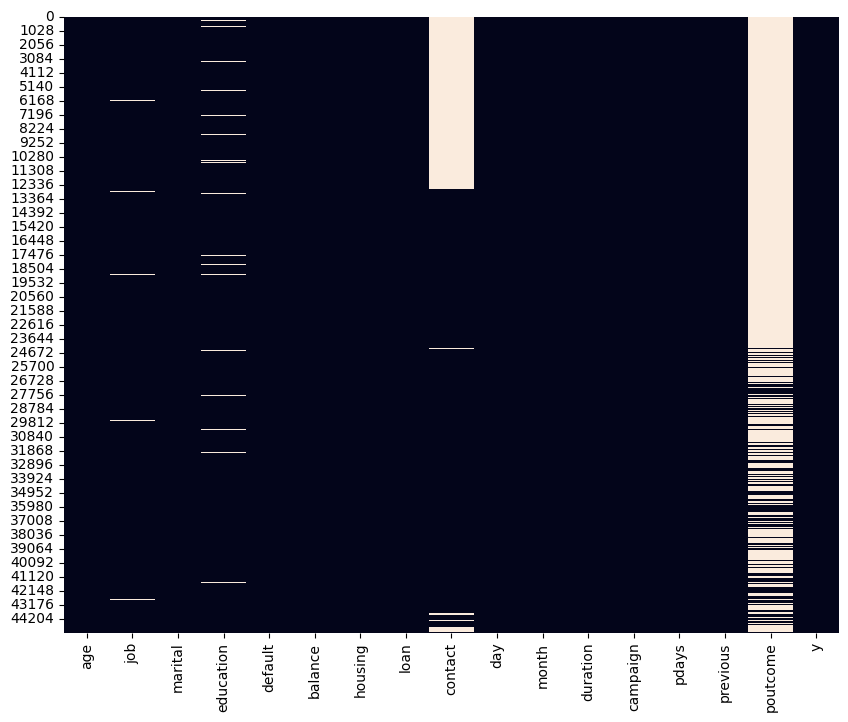

In [8]:
plt.figure(figsize=(10,8))
sns.heatmap(df.isna(), cbar=False)

In [9]:
df.dropna(axis=0)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
24060,33,admin.,married,tertiary,no,882,no,no,telephone,21,oct,39,1,151,3,failure,no
24062,42,admin.,single,secondary,no,-247,yes,yes,telephone,21,oct,519,1,166,1,other,yes
24064,33,services,married,secondary,no,3444,yes,no,telephone,21,oct,144,1,91,4,failure,yes
24072,36,management,married,tertiary,no,2415,yes,no,telephone,22,oct,73,1,86,4,other,no
24077,36,management,married,tertiary,no,0,yes,no,telephone,23,oct,140,1,143,3,failure,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45199,34,blue-collar,single,secondary,no,1475,yes,no,cellular,16,nov,1166,3,530,12,other,no
45201,53,management,married,tertiary,no,583,no,no,cellular,17,nov,226,1,184,4,success,yes
45204,73,retired,married,secondary,no,2850,no,no,cellular,17,nov,300,1,40,8,failure,yes
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        44923 non-null  object
 2   marital    45211 non-null  object
 3   education  43354 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    32191 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   8252 non-null   object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [11]:
#  Counting missing values
df.isna().sum()

age              0
job            288
marital          0
education     1857
default          0
balance          0
housing          0
loan             0
contact      13020
day              0
month            0
duration         0
campaign         0
pdays            0
previous         0
poutcome     36959
y                0
dtype: int64

In [12]:
# Percentage of missing values in each column
((df.isna().sum()/df.shape[0])*100).apply(lambda x: f'{x:.1f} %')

age           0.0 %
job           0.6 %
marital       0.0 %
education     4.1 %
default       0.0 %
balance       0.0 %
housing       0.0 %
loan          0.0 %
contact      28.8 %
day           0.0 %
month         0.0 %
duration      0.0 %
campaign      0.0 %
pdays         0.0 %
previous      0.0 %
poutcome     81.7 %
y             0.0 %
dtype: object

In [13]:
# drop 'poutcome' column since it countains lot of missing values
# drop 'duration' because we can't know the duration before making the call
df.drop(['poutcome','duration'], axis=1, inplace=True)

In [14]:
# How many different values are there in each column
df.nunique()

age            77
job            11
marital         3
education       3
default         2
balance      7168
housing         2
loan            2
contact         2
day            31
month          12
campaign       48
pdays         559
previous       41
y               2
dtype: int64

### Target variable

In [15]:
#df['y'] = df['y'].map({'yes':1, 'no':0})
target_mapping = {label: idx for idx, label in enumerate(df['y'].unique())}
df['y'] = df['y'].map(target_mapping)
df['y']

0        0
1        0
2        0
3        0
4        0
        ..
45206    1
45207    1
45208    1
45209    0
45210    0
Name: y, Length: 45211, dtype: int64

In [16]:
df['y'].value_counts()

y
0    39922
1     5289
Name: count, dtype: int64

In [17]:
(df['y'].value_counts(normalize=True) * 100).apply(lambda x:f'{x:.1f} %')

y
0    88.3 %
1    11.7 %
Name: proportion, dtype: object

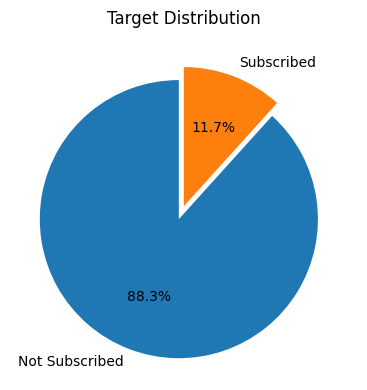

In [18]:
plt.figure(figsize=(6,4))
plt.title('Target Distribution')
plt.pie(df['y'].value_counts(), labels=['Not Subscribed', 'Subscribed'], autopct='%1.1f%%', startangle=90, explode=(0.1, 0))
plt.tight_layout()
plt.show()

### Numerical and categorial variables

In [19]:
cat_features = df.drop('y', axis=1).select_dtypes(include='object').columns
cat_features

Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month'],
      dtype='object')

In [20]:
num_features = df.select_dtypes(include='int').columns
num_features

Index(['age', 'balance', 'day', 'campaign', 'pdays', 'previous', 'y'], dtype='object')

### Encoding

In [21]:
#df_encoded = pd.get_dummies(df, columns=cat_features) # one hot encoding
df_encoded = df.copy()
for cat_column in cat_features:
    mapping = {label: idx for idx, label in enumerate(df_encoded[cat_column].unique())}
    df_encoded[cat_column] = df_encoded[cat_column].map(mapping)
df_encoded.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,y
0,58,0,0,0,0,2143,0,0,0,5,0,1,-1,0,0
1,44,1,1,1,0,29,0,0,0,5,0,1,-1,0,0
2,33,2,0,1,0,2,0,1,0,5,0,1,-1,0,0
3,47,3,0,2,0,1506,0,0,0,5,0,1,-1,0,0
4,33,4,1,2,0,1,1,0,0,5,0,1,-1,0,0


### Correlation matrix

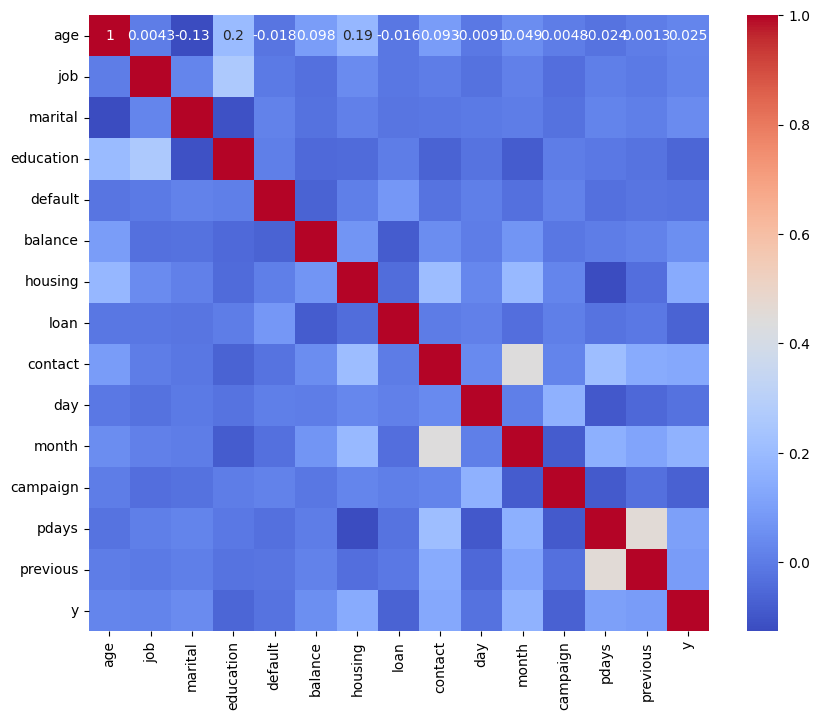

In [22]:
corr_matrix = df_encoded.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True)
plt.show()

### Split dataframe to train, val and test data

In [23]:
#mvp_columns = ['age', 'job', 'balance', 'day',
#       'month', 'campaign', 'pdays', 'y']
#df_encoded = df_encoded[mvp_columns]
#df_encoded.columns

In [24]:
y = df_encoded['y']
X = df_encoded.drop('y', axis=1)

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=0)

### Over Sampling

In [26]:
smote = SMOTE(random_state=0)
X_train, y_train = smote.fit_resample(X_train,y_train)

### Decision Tree Model

In [27]:
model = Pipeline(steps=[('selectkbest', SelectKBest(f_classif, k=6)),
                       ('decisiontree', DecisionTreeClassifier(class_weight='balanced', random_state=0))])
#model = DecisionTreeClassifier(class_weight='balanced', random_state=0)                         

In [28]:
# Evaluation function
def evaluation(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(confusion_matrix(y_test,y_pred))
    print(classification_report(y_test,y_pred))
    N, train_score, val_score = learning_curve(model,X_train,y_train,cv=4,
                                               train_sizes=np.linspace(0.1,1,10),
                                               scoring='f1')
    plt.figure(figsize=(12,8))
    plt.plot(N, train_score.mean(axis=1), label='train score')
    plt.plot(N, val_score.mean(axis=1), label='validation score')
    plt.legend()
    return y_pred

[[6001 1979]
 [ 516  547]]
              precision    recall  f1-score   support

           0       0.92      0.75      0.83      7980
           1       0.22      0.51      0.30      1063

    accuracy                           0.72      9043
   macro avg       0.57      0.63      0.57      9043
weighted avg       0.84      0.72      0.77      9043



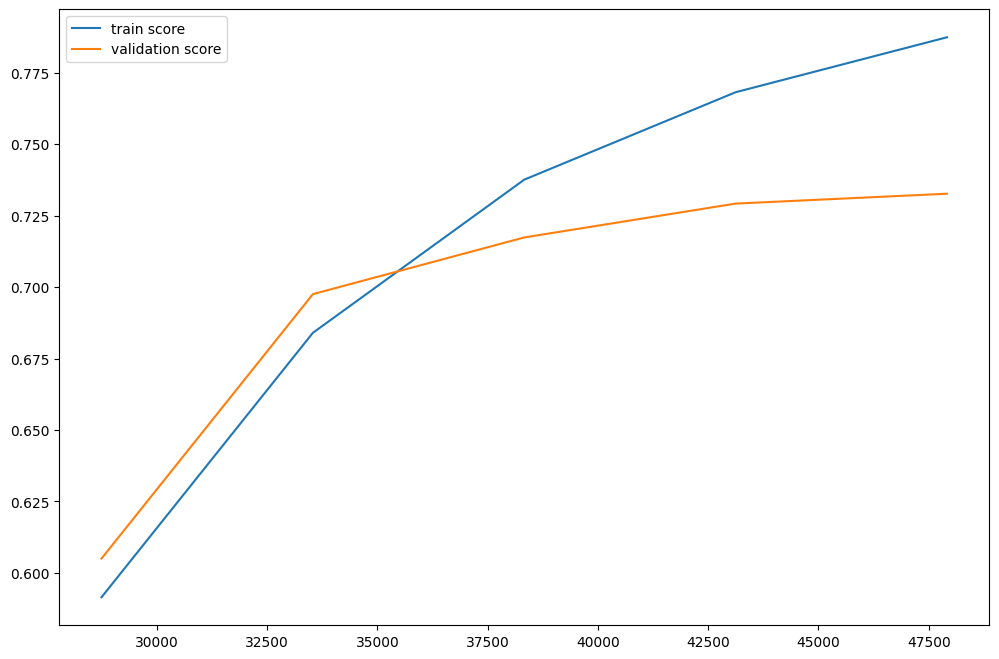

In [29]:
y_pred = evaluation(model, X_train, X_test, y_train, y_test)

In [30]:
# Recall metric is more important than accuracy in this case so we can sacrifice accuracy a little bit
# the best accuracy i got was 80% (and 46% recall) with SelectKBest when k=10
# we can even get 84% accuracy without using Smote and SelectKBest but only 31% recall
# to get a better recall = 51%, i'm happy with an accuracy = 72%
recall = recall_score(y_test, y_pred)
recall

0.5145813734713076

In [31]:
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.7240959858454052